# Wheel data
Feb2023 \
author: Inês Laranjeira

In [2]:
"""
IMPORTS
"""
import pandas as pd 
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pickle


#%matplotlib notebook

import re
import sys
import os
from brainbox.io.one import load_wheel_reaction_times
import brainbox.behavior.wheel as wh
from ibllib.io.extractors.ephys_fpga import extract_wheel_moves
from ibllib.io.extractors.training_wheel import extract_first_movement_times
# from ibllib.misc.exp_ref import eid2ref
from one.api import ONE

one = ONE()
sns.set_style('whitegrid')

# --Get my functionsS
# functions_path = "../Functions/"
# os.chdir(functions_path)
# from one_functions_generic import get_trials, performance_metrics, bin_frac, prepro


In [3]:
device_info = ('The wheel diameter is {} cm and the number of ticks is {} per revolution'
               .format(wh.WHEEL_DIAMETER, wh.ENC_RES))
print(device_info)


The wheel diameter is 6.2 cm and the number of ticks is 4096 per revolution


In [4]:

eid = 'eafbdb1a-8776-4390-b210-76b7509e31d0'
wheel = one.load_object(eid, 'wheel', collection='alf')

print('wheel.position: \n', wheel.position)
print('wheel.timestamps: \n', wheel.timestamps)

wheel.position: 
 [-3.86563159e-01 -3.92699082e-01 -3.98835005e-01 ... -5.65799610e+02
 -5.65805746e+02 -5.65811882e+02]
wheel.timestamps: 
 [6.79604098e-01 6.86161141e-01 6.92652183e-01 ... 3.73136665e+03
 3.73138577e+03 3.73141459e+03]


If the dataset doesn't exist you can also extract the wheel moves with a single function. Below we attempt to load the wheelMoves ALF and upon failing, extract it ourselves.

In [9]:
try:
    # Warning: Some older sessions may not have a wheelMoves dataset
    wheel_moves = one.load_object(eid, 'wheelMoves', collection='alf')
    assert wheel_moves, 'object not found'
except AssertionError:
    wheel_moves = extract_wheel_moves(wheel.timestamps, wheel.position)

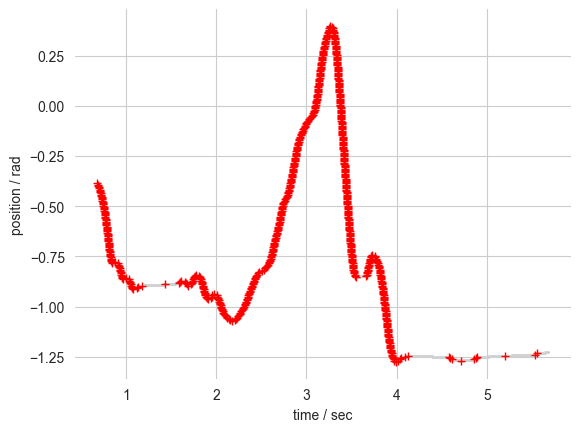

In [6]:
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position)
sec = 5  # Number of seconds to plot
plt.figure()

# Plot the interpolated data points
mask = t < (t[0] + sec)
plt.plot(t[mask], pos[mask], '.', markeredgecolor='lightgrey', markersize=1)

# Plot the original data
mask = wheel.timestamps < (wheel.timestamps[0] + sec)
plt.plot(wheel.timestamps[mask], wheel.position[mask], 'r+', markersize=6)

# Labels etc.
plt.xlabel('time / sec')
plt.ylabel('position / rad')
plt.box(on=None)

In [10]:
wheel_moves

{'peakAmplitude': array([-0.52573402,  1.28695114, -0.01843999, ...,  0.09306042,
        -0.06072703, -0.00927136]),
 'intervals': array([[6.81604098e-01, 1.12560410e+00],
        [1.47360410e+00, 4.05360410e+00],
        [4.57360410e+00, 4.87260410e+00],
        ...,
        [3.72733260e+03, 3.72814360e+03],
        [3.72878460e+03, 3.72892460e+03],
        [3.72972160e+03, 3.72983460e+03]])}

In [7]:


# Convert the pos threshold defaults from samples to correct unit
thresholds_cm = wh.samples_to_cm(np.array([8, 1.5]), resolution=wh.ENC_RES)
thresholds = wh.cm_to_rad(thresholds_cm)



In [8]:
thresholds

array([0.01227185, 0.00230097])

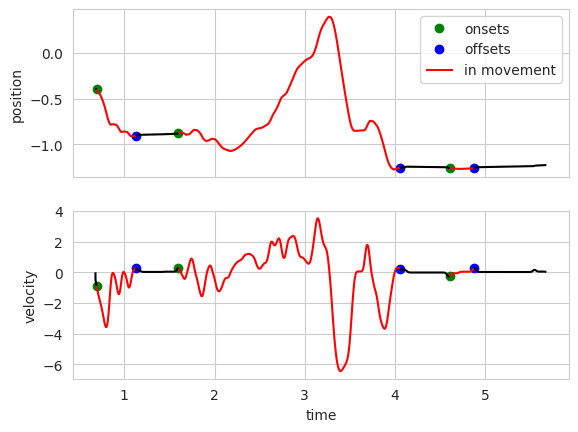

In [9]:
# Detect wheel movements for the first 5 seconds
mask = t < (t[0] + sec)

onsets, offsets, peak_amp, peak_vel_times = wh.movements(
    t[mask], pos[mask], pos_thresh=thresholds[0], pos_thresh_onset=thresholds[0], make_plots=True)



In [16]:
threshold_deg = 35 # visual degrees
gain = 4  # deg / mm
threshold_rad = wh.cm_to_rad(1e-1) * (threshold_deg / gain)  # rad

print('The wheel must be turned ~%.1f rad to move the stimulus to threshold' % threshold_rad)

The wheel must be turned ~0.3 rad to move the stimulus to threshold


In [17]:
# pos was the output of interpolate_position using the default frequency of 1000Hz
Fs = 1000
pos, t = wh.interpolate_position(wheel.timestamps, wheel.position, freq=Fs)
vel, acc = wh.velocity_smoothed(pos, Fs)

In [20]:
trial_data.keys()

dict_keys(['included', 'goCueTrigger_times', 'stimOnTrigger_times', 'goCue_times', 'probabilityLeft', 'feedback_times', 'stimOn_times', 'contrastLeft', 'contrastRight', 'choice', 'feedbackType', 'rewardVolume', 'firstMovement_times', 'response_times', 'intervals'])

/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL055/2020-02-10/001/alf/_ibl_trials.included.npy: 100%|██████████| 867/867 [00:00<00:00, 2.41kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL055/2020-02-10/001/alf/_ibl_trials.goCueTrigger_times.npy: 100%|██████████| 6.04k/6.04k [00:00<00:00, 18.9kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL055/2020-02-10/001/alf/_ibl_trials.table.pqt: 100%|██████████| 58.8k/58.8k [00:00<00:00, 95.4kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/churchlandlab/Subjects/CSHL055/2020-02-10/001/alf/_ibl_trials.stimOnTrigger_times.npy: 100%|██████████| 6.04k/6.04k [00:00<00:00, 19.8kB/s]


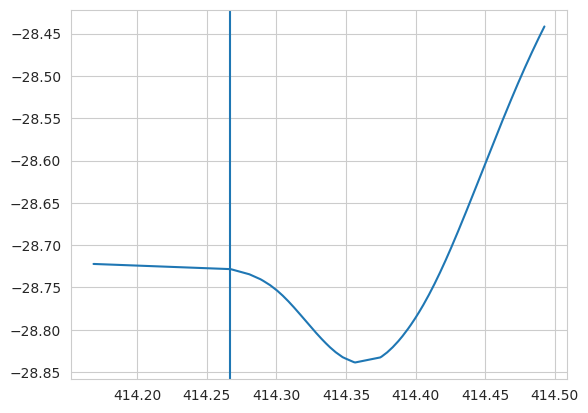

In [18]:
trial_data = one.load_object(eid, 'trials', collection='alf')
idx = 23 # trial index
ts = wh.last_movement_onset(t, vel, trial_data['feedback_times'][idx]);

mask = np.logical_and(trial_data['goCue_times'][idx] < t, t < trial_data['feedback_times'][idx])
plt.figure();
plt.plot(t[mask], pos[mask]);
plt.axvline(x=ts);

In [21]:
# Load the reaction times
# brainbox.io.one.load_wheel_reaction_times
rt = load_wheel_reaction_times(eid)

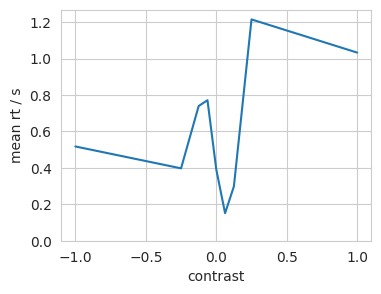

In [22]:
trial_data = one.load_object(eid, 'trials', collection='alf')

# # Replace nans with zeros
trial_data.contrastRight[np.isnan(trial_data.contrastRight)] = 0
trial_data.contrastLeft[np.isnan(trial_data.contrastLeft)] = 0

contrast = trial_data.contrastRight - trial_data.contrastLeft
mean_rt = [np.nanmean(rt[contrast == c]) for c in set(contrast)]

# RT may be nan if there were no detected movements, or if the goCue or stimOn times were nan
xdata = np.unique(contrast)
plt.figure(figsize=(4, 3))  # Some sort of strange behaviour in this cell's output
plt.plot(xdata, mean_rt);

plt.xlabel('contrast')
plt.ylabel('mean rt / s')
plt.ylim(bottom=0);

In [23]:
firstMove_times, is_final_movement, ids = extract_first_movement_times(wheel_moves, trial_data)

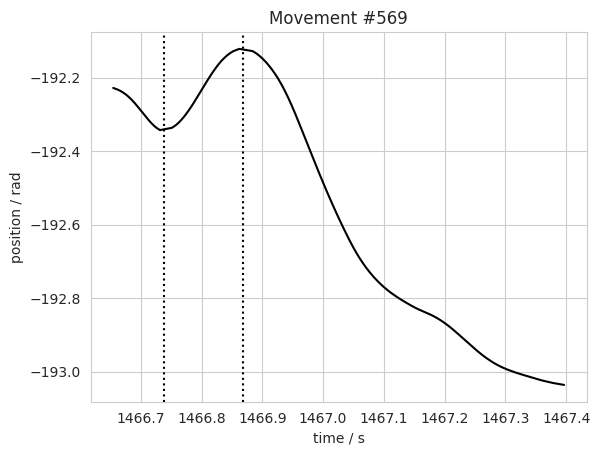

In [24]:
n = 569
on, off = wheel_moves['intervals'][n,]
mask = np.logical_and(t > on, t < off)
sng = np.sign(vel[mask])
idx, = np.where(np.diff(sng) != 0)

plt.figure()
plt.plot(t[mask], pos[mask], 'k')
for i in idx:
    plt.axvline(x=t[mask][i], color='k', linestyle=':')

plt.title('Movement #%s' % n)
plt.xlabel('time / s')
plt.ylabel('position / rad');

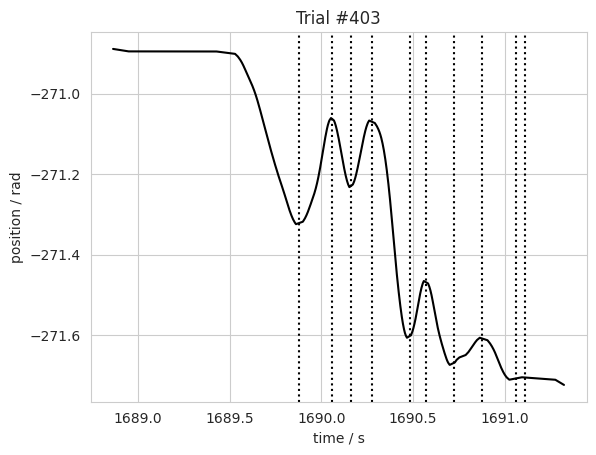

In [25]:
n = 403  # trial number
start, end = trial_data['intervals'][n,]  # trial intervals
intervals = wheel_moves['intervals']  # movement onsets and offsets

# Find direction changes for a given trial
mask = np.logical_and(intervals[:,0] > start, intervals[:,0] < end)
change_times, idx, = wh.direction_changes(t, vel, intervals[mask])

plt.figure()
mask = np.logical_and(t > start, t < end)  # trial intervals mask
plt.plot(t[mask], pos[mask], 'k')  # plot wheel trace for trial
for i in np.concatenate(change_times):
    plt.axvline(x=i, color='k', linestyle=':')

plt.title('Trial #%s' % n)
plt.xlabel('time / s')
plt.ylabel('position / rad');

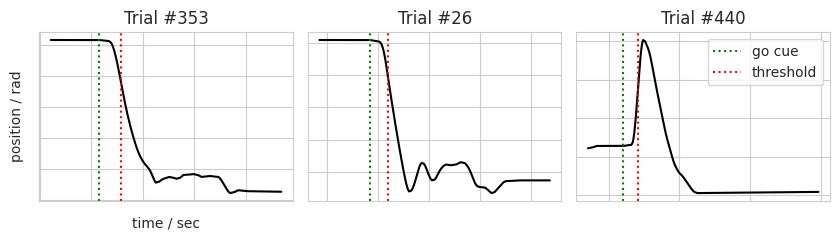

In [26]:
n_trials = 3  # Number of trials to plot
# Randomly select the trials to plot
trial_ids = np.random.randint(trial_data['choice'].size, size=n_trials)
fig, axs = plt.subplots(1, n_trials, figsize=(8.5,2.5))
plt.tight_layout()

# Plot go cue and response times
goCues = trial_data['goCue_times'][trial_ids]
responses = trial_data['response_times'][trial_ids]

# Plot traces between trial intervals
starts = trial_data['intervals'][trial_ids, 0]
ends = trial_data['intervals'][trial_ids, 1]
# Cut up the wheel vectors
traces = wh.traces_by_trial(t, pos, start=starts, end=ends)
zipped = zip(traces, axs, goCues, responses, trial_ids)

for (trace, ax, go, resp, n) in zipped:
    ax.plot(trace[0], trace[1], 'k-')
    ax.axvline(x=go, color='g', label='go cue', linestyle=':')
    ax.axvline(x=resp, color='r', label='threshold', linestyle=':')
    ax.set_title('Trial #%s' % n)

    # Turn off tick labels
    ax.set_yticklabels([])
    ax.set_xticklabels([])

# Add labels to first
axs[0].set_xlabel('time / sec')
axs[0].set_ylabel('position / rad')
plt.legend();
plt.tight_layout()

In [5]:
from one.api import ONE
one = ONE()
eid = '4ecb5d24-f5cc-402c-be28-9d0f7cb14b3a'

wheel = one.load_object(eid, 'wheel', collection='alf')
wheelMoves = one.load_object(eid, 'wheelMoves', collection='alf')

/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/_ibl_wheel.timestamps.npy: 100%|██████████| 8.08M/8.08M [00:15<00:00, 525kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/_ibl_wheel.position.npy: 100%|██████████| 8.08M/8.08M [00:11<00:00, 690kB/s] 
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/_ibl_wheelMoves.peakAmplitude.npy: 100%|██████████| 13.4k/13.4k [00:00<00:00, 36.8kB/s]
/home/ines/Downloads/ONE/alyx.internationalbrainlab.org/hoferlab/Subjects/SWC_043/2020-09-21/001/alf/_ibl_wheelMoves.intervals.npy: 100%|██████████| 26.6k/26.6k [00:00<00:00, 80.8kB/s]


In [7]:
wheelMoves

{'peakAmplitude': array([-0.40741975,  0.33989123,  0.86276725, ...,  0.03335082,
        -0.12215074,  0.14676156]),
 'intervals': array([[3.24973500e-02, 7.96497350e-01],
        [2.12249735e+00, 3.85949735e+00],
        [5.50649735e+00, 7.33849735e+00],
        ...,
        [4.27439350e+03, 4.27448550e+03],
        [4.28801150e+03, 4.28836950e+03],
        [4.29496650e+03, 4.29526550e+03]])}

## Get data

In [ ]:
""" 
GET LEARNING DATA
"""
trials = pickle.load(open("learning_private_one", "rb"))
#trials = pickle.load(open("training_time_private_one", "rb"))
